motivation: tpus are suspended all the time, so curves are segmented

In [39]:
import json
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

experiments_dict = {
    "clip": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_bs16384_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_12lyr_07-25_1415",
    # "clip_s9b_bs32k": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_s9b_bs32k_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_08-09_0655",
    # "contrastive_freeze_llm": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-T_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-18_0712",
    "contrastive_unfreeze_llm": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-20_2032",
    # "contrastive_unfreeze_llm_6lyr": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-6lyr-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-20_2032",
    # "contrastive_unfreeze_llm_half": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-21_1935",
    # "contrastive_unfreeze_llm_half_scratch": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-scratch-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-22_0327",
    # "generative_unfreeze_llm_half": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-pretrained-0.1_so400m-F_generative_bs16384_s3b_wd1e-4_08-22_0402",
    # "contrastive_unfreeze_llm_half_s9b_bs32k": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-0.1_b16-F_contrastive_bs32768_s9b_wd1e-4_08-21_1935",
    # "contrastive_unfreeze_llm_6lyr_map": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-6lyr-0.1-map_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-27_1857",
    # "contrastive_unfreeze_llm_ln_gap": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-ln-0.1-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-28_1538",
    "contrastive_9+9_llm_gap": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.1-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-28_1934"
}

def get_metrics(experiment_name, x_axis='examples_seen', y_axis='z/0shot/imagenet2012_accuracy'):
    ckpt_path = experiments_dict[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    metrics = {}
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        for line in lines:
            if len(line) == 0:
                continue
            line_dict = json.loads(line)
            if line_dict['step'] % 1000 == 0:
                x = line_dict[x_axis]
                y = line_dict[y_axis] if y_axis in line_dict else None
                if y is not None:
                    metrics[x] = y
    return metrics

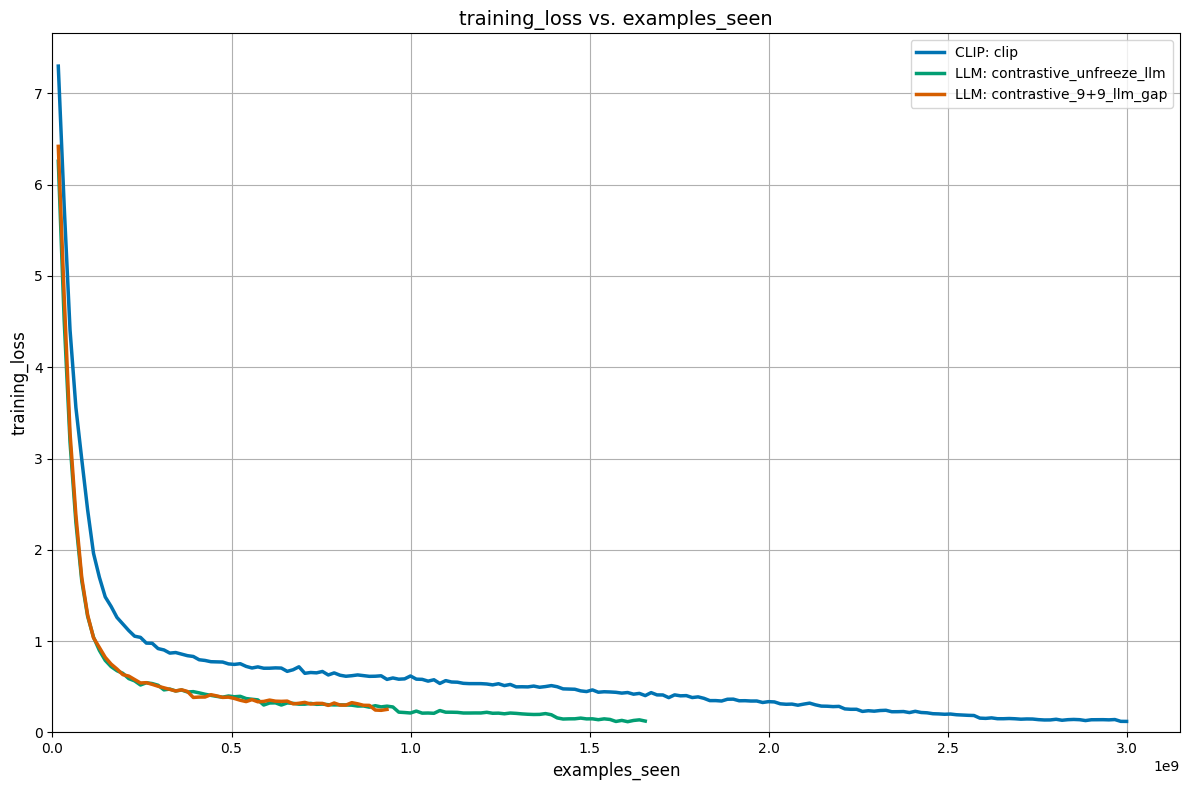

In [40]:
# Collect data for all experiments
x_axis = 'examples_seen' 
# step, examples_seen, core_hours, 
# global_schedule, lr, lr_schedule, uptime, progress, epoch, core_hours_TPU v4
y_axis = 'z/0shot/imagenet2012_accuracy'
y_axis = 'training_loss'
# l2_grads, l2_params, l2_updates, training_loss,
# z/retr/coco_img2txt_recall@1, z/retr/coco_img2txt_recall@5, z/retr/coco_img2txt_recall@10,
# z/retr/coco_txt2img_recall@1, z/retr/coco_txt2img_recall@5, z/retr/coco_txt2img_recall@10,
# z/0shot/imagenet2012_accuracy, z/0shot/imagenet_v2_accuracy, z/0shot/imagenet2012_real_accuracy
all_metrics = {}
for experiment_name in experiments_dict.keys():
    all_metrics[experiment_name] = get_metrics(experiment_name, x_axis=x_axis, y_axis=y_axis)



# Define color schemes for clip and llm groups
palette = sns.color_palette("colorblind", 8)
clip_colors = [palette[0], palette[1]]  # Two distinct colors for CLIP
llm_colors = palette[2:]  # Remaining colors for LLM

# Plot all experiments on the same graph
plt.figure(figsize=(12, 8))

clip_experiments = [exp for exp in experiments_dict.keys() if 'clip' in exp]
llm_experiments = [exp for exp in experiments_dict.keys() if 'llm' in exp]

# Plot CLIP experiments
for i, experiment_name in enumerate(clip_experiments):
    metrics = all_metrics[experiment_name]
    linestyle = '--' if 's9b_bs32k' in experiment_name else '-'
    plt.plot(list(metrics.keys()), list(metrics.values()), label=f'CLIP: {experiment_name}', 
             color=clip_colors[i % len(clip_colors)], linewidth=2.5, linestyle=linestyle)

# Plot LLM experiments
for i, experiment_name in enumerate(llm_experiments):
    metrics = all_metrics[experiment_name]
    linestyle = '--' if 's9b_bs32k' in experiment_name else '-'
    plt.plot(list(metrics.keys()), list(metrics.values()), label=f'LLM: {experiment_name}', 
             color=llm_colors[i % len(llm_colors)], linewidth=2.5, linestyle=linestyle)

plt.xlabel(f'{x_axis}', fontsize=12)
plt.ylabel(f'{y_axis}', fontsize=12)
plt.xlim(0)
plt.ylim(0)
plt.legend(fontsize=10)
plt.title(f'{y_axis} vs. {x_axis}', fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

# # Plot all experiments on the same graph
# plt.figure(figsize=(12, 8))
# for experiment_name, metrics in all_metrics.items():
#     linestyle = '-.' if 's9b_bs32k' in experiment_name else '-'
#     plt.plot(list(metrics.keys()), list(metrics.values()), label=experiment_name, linewidth=2.5, linestyle=linestyle)
# plt.xlabel(f'{x_axis}', fontsize=12)
# plt.ylabel(f'{y_axis}', fontsize=12)
# plt.xlim(0)
# plt.ylim(0)
# plt.legend(fontsize=10)
# plt.title(f'{y_axis} vs. {x_axis}', fontsize=14)
# plt.grid(True)
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.show()

In [41]:
# Print final metrics for each experiment
for experiment_name, metrics in all_metrics.items():
    final_metric = list(metrics.values())[-1]
    print(f"Final {experiment_name} metric: {final_metric}")

Final clip metric: 0.12100432813167572
Final contrastive_unfreeze_llm metric: 0.12457410991191864
Final contrastive_9+9_llm_gap metric: 0.2523159980773926
